# Autonomous Driving Rover
**Leonardo Russo 2015563**

### Introduction

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from library import *
from scipy.integrate import solve_ivp
import pickle
import os
import sympy as sp
from tqdm import tqdm
from pprint import pprint
from matplotlib.patches import Ellipse
from matplotlib.patches import Circle


# Load Map Data
X, Y, map_image, obstacleMap, xLM, yLM, Xvec, Yvec = load_data()

# Define Map Resolution
mapRes = 10     # meters per pixel

# Define Physical Values
L = 3           # m - axles distance
v_max = 4e-2    # m/s - max speed

# Define Initial and Intermediate Poses
P0 = np.array([42.38*1e3, 11.59*1e3, np.pi/2])          # m, m, rad
P1 = np.array([33.07*1e3, 19.01*1e3, np.pi])            # m, m, rad

figres = 1000

### Task 1: Navigation - Moving to a Pose

The first task requires the Rover to reach a first new pose using the Moving to a Pose control law.

The gains were selected as follows:
`K = [1e-1, 1.45e-1, -1.9e-1]`

In [12]:
def KinematicModel(P_start, P_end, K, rho_tol, t0=0, tf=days2sec(10), freq=1):
    
    # Compute Initial Relative State
    R0 = P2R(P_start, P_end)

    # Define Time Domain
    tspan = np.arange(t0, tf + 1, 1 / freq)

    # Initialize variables for Euler integration
    R = np.zeros((R0.shape[0], len(tspan)))
    dR = np.zeros((R0.shape[0], len(tspan)))
    u = np.zeros((2, len(tspan)))
    R[:, 0] = R0
    reached_target = False

    # Perform Euler Integration
    for i in range(1, len(tspan)):
        dt = tspan[i] - tspan[i-1]

        # Unpack State Variables
        rho, alpha, beta = R[:, i-1]

        # Compute Control
        v, omega = Move2Pose(R[:, i-1], K)

        # Compute Derivatives
        drho = -np.cos(alpha) * v
        dalpha = np.sin(alpha) * v / rho - omega
        dbeta = -np.sin(alpha) * v / rho

        # Euler Integration
        u[:, i] = np.array([v, omega])
        dR[:, i] = np.array([drho, dalpha, dbeta])
        R[:, i] = R[:, i-1] + dR[:, i] * dt

        # Check for Arrival
        if rho <= rho_tol:
            reached_target = True
            break

    if reached_target:
        R = R[:, :i + 1]
        dR = dR[:, :i + 1]
        u = u[:, :i + 1]
        tspan = tspan[:i + 1]

    return R2P(R, P_end), u, tspan

# Define Viapoints
viapoints = np.array([P1])      # free trajectory
# viapoints = np.array([[41441.8043, 15352.0639, np.pi/2 + np.pi/3], P1])

# Select Gains and Tolerance
# K = np.array([1e-4, 1.4e-3, -1.8e-3])
K = np.array([1e-1, 1.45e-1, -1.9e-1])
rho_tol = 0.1  # m

# Initialize Variables
P = np.empty((3, 0))  # P is 3 x N
u = np.empty((2, 0))  # u is 2 x N
tspan = np.array([])

# Initialize Loop Variables
P_start = P0
t_start = 0

# Perform the Integration
for i in range(len(viapoints)):

    P_int, u_int, tspan_int = KinematicModel(P_start, viapoints[i], K, rho_tol, t_start)

    # Stack the results
    P = np.hstack((P, P_int))
    u = np.hstack((u, u_int))
    tspan = np.concatenate((tspan, tspan_int))

    # Check for obstacles
    P_indices = np.array([get_indices(P_int[0:2, i], X, Y, mapRes) for i in range(P_int.shape[1])])
    if check_obstacles(P_indices, obstacleMap):
        print('\n\nThe Trajectory intersects with an Obstacle!\n')
        break

    P_start = P_int[:, -1]          # store the real final state -> start of next segment
    t_start = tspan_int[-1]         # store the real final time -> start of next segment


P1r = P[:, -1]  # store the real final state


Task 1
______________________________________________________________________ 

The Initial State is:	 [4.23800000e+04 1.15900000e+04 1.57079633e+00]
The Final State is:	 [3.30700871e+04 1.90100000e+04 3.14159350e+00]
The Desired State is:	 [3.30700000e+04 1.90100000e+04 3.14159265e+00]

The Delta State is:	 [8.71156503e-02 2.20825314e-09 8.46740335e-07]
Final Time is:		 3.85 days


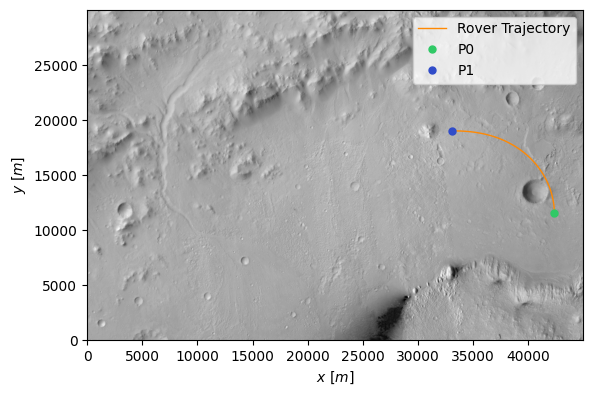

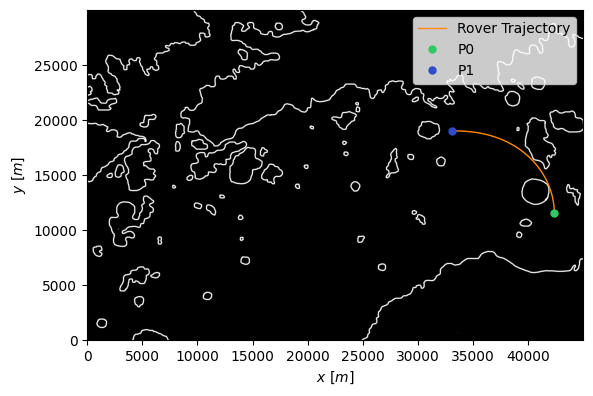

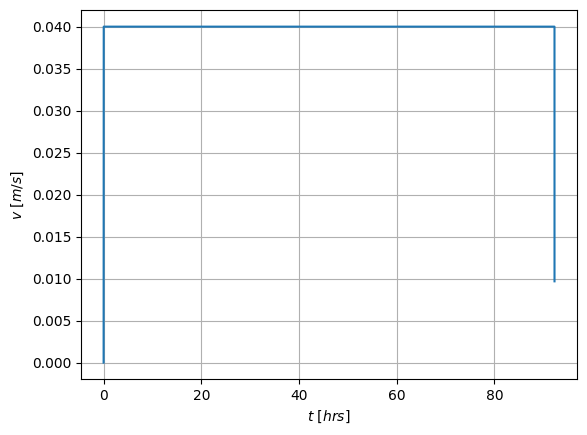

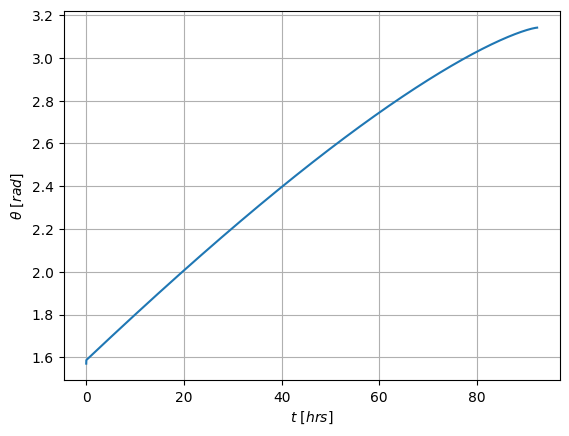

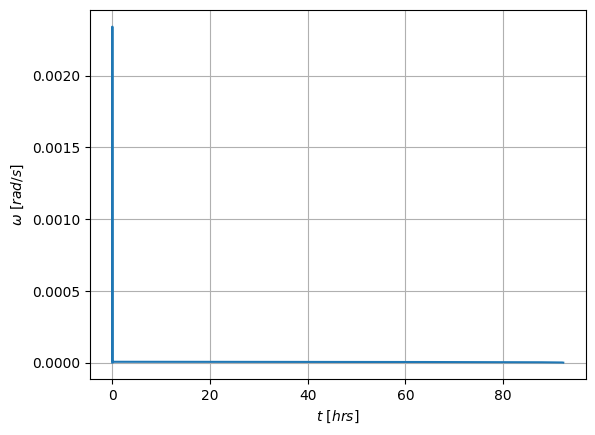

In [13]:
# Print Results
print('\nTask 1\n' + '_' * 70, '\n\nThe Initial State is:\t', P0)
print('The Final State is:\t', P[:, -1])
print('The Desired State is:\t', P1)
print('\nThe Delta State is:\t', P[:, -1] - P1)
print('Final Time is:\t\t {:.2f} days'.format(sec2days(tspan[-1])))

# Show Trajectory in Map
plt.figure()
plot_map(map_image, Xvec, Yvec)
plt.plot(P[0, :], P[1, :], '#ff8903', linestyle='-', linewidth=1, label='Rover Trajectory')
plt.plot(P0[0], P0[1], linestyle='none', marker='.', markersize=10, color='#30c966', label='P0')
plt.plot(P1[0], P1[1], linestyle='none', marker='.', markersize=10, color='#304cc9', label='P1')
plt.xlabel(r'$x \ [m]$')
plt.ylabel(r'$y \ [m]$')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.savefig('Images/nav_traj.jpg', format='jpg', dpi=figres)
plt.show()

# Show Trajectory in Obstacle Map
plt.figure()
plt.imshow(obstacleMap, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.plot(P[0, :], P[1, :], '#ff8903', linestyle='-', linewidth=1, label='Rover Trajectory')
plt.plot(P0[0], P0[1], linestyle='none', marker='.', markersize=10, color='#30c966', label='P0')
plt.plot(P1[0], P1[1], linestyle='none', marker='.', markersize=10, color='#304cc9', label='P1')
plt.xlabel(r'$x \ [m]$')
plt.ylabel(r'$y \ [m]$')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.savefig('Images/nav_traj_obst.jpg', format='jpg', dpi=figres)
plt.show()


# Visualize the Linear Velocity
plt.figure()
plt.plot(tspan/60**2, u[0, :], label='v')
plt.xlabel(r'$t \ [hrs]$')
plt.ylabel(r'$v \ [m/s]$')
plt.grid(True)
plt.savefig('Images/v.jpg', format='jpg', dpi=figres)
plt.show()

# Visualize the Heading Angle
plt.figure()
plt.plot(tspan/60**2, P[2, :], label='theta')
plt.xlabel(r'$t \ [hrs]$')
plt.ylabel(r'$\theta \ [rad]$')
plt.grid(True)
plt.savefig('Images/theta.jpg', format='jpg', dpi=figres)
plt.show()

# Visualize the Angular Velocity
plt.plot(tspan/60**2, u[1, :], label='omega')
plt.xlabel(r'$t \ [hrs]$')
plt.ylabel(r'$\omega \ [rad/s]$')
plt.grid(True)
plt.savefig('Images/omega.jpg', format='jpg', dpi=figres)
plt.show()

### Task 2: Path Planning - A* Algorithm

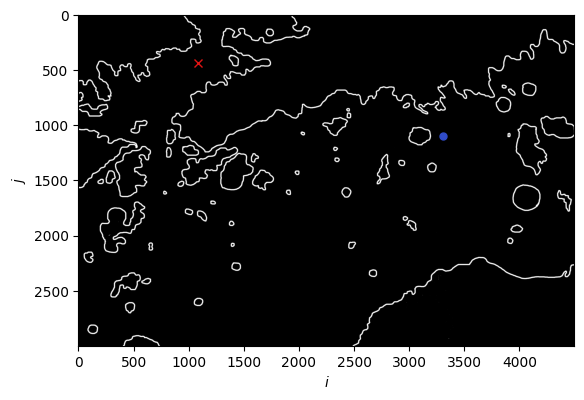

In [14]:
# Define Start and End Coordinates
start = P1r[0:2]
end = np.array([10.87e3, 25.67e3])

# Convert to Map Indices
start = get_indices(start, X, Y, mapRes)
end = get_indices(end, X, Y, mapRes)

# Obstacle Map
plt.figure("Initial and Final Coordinates in Obstacle Map")
plt.imshow(obstacleMap, cmap='gray')
plt.plot(start[1], start[0], linestyle='none', marker='.', markersize=10, color='#304cc9', label='P1')
plt.plot(end[1], end[0], linestyle='none', marker='x', markersize=6, color='#e01414', label='P2')
plt.xlabel(r'$i$')
plt.ylabel(r'$j$')
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('Images/Astar_IC.jpg', format='jpg', dpi=figres)
plt.show()

#### Define A* Algorithm Function

In [15]:
def A_star(start, end, obstacle_map):
    class Node:
        def __init__(self, position, parent):
            self.position = tuple(position)  # Store position as a tuple
            self.parent = parent
            self.g = 0  # Distance to start node
            self.h = 0  # Distance to goal node
            self.f = 0  # Total cost

        def __eq__(self, other):
            return self.position == other.position

        def __hash__(self):
            return hash(self.position)  # Hash based on position for use in sets

    # Heuristic Function
    def heuristic(n, goal):    # Octile Distance
        return max(abs(n[0]-goal[0]), abs(n[1]-goal[1])) + 0.41421356237 * min(abs(n[0]-goal[0]), abs(n[1]-goal[1]))
    
    # Check whether a neighbor should be added to the Open list
    def add_to_open(open_list, neighbor):
        for node in open_list:
            if neighbor == node and neighbor.f >= node.f:
                return False
        return True

    open_list = []
    closed_list_set = set()

    start_node = Node(start, None)
    end_node = Node(end, None)
    open_list.append(start_node)

    while len(open_list) > 0:
        current_node = min(open_list, key=lambda node: node.f)
        open_list.remove(current_node)
        closed_list_set.add(current_node)

        if current_node.position == end_node.position:
            path = []
            while current_node:
                path.append(current_node.position)
                current_node = current_node.parent
            return path[::-1]  # Return reversed path

        # Generate children
        (x, y) = current_node.position
        neighbors = [(x, y-1), (x-1, y-1), (x-1, y), (x-1, y+1), (x, y+1), (x+1, y+1), (x+1, y), (x+1, y-1)]

        for next_node in neighbors:
            # Make sure within range
            if next_node[0] > (len(obstacle_map) - 1) or next_node[0] < 0 or next_node[1] > (len(obstacle_map[0]) - 1) or next_node[1] < 0:
                continue

            # Make sure walkable terrain
            if int(obstacle_map[next_node[0]][next_node[1]]) == 255:  # Convert to int for comparison
                continue

            # Create new node
            neighbor = Node(next_node, current_node)

            # Check if the neighbor is in the closed list
            if neighbor in closed_list_set:
                continue

            # Determine movement cost -> straight: 1, diagonal: sqrt(2)
            if x != next_node[0] and y != next_node[1]:
                movement_cost = 1.41421356237
            else:
                movement_cost = 1

            # Create the f, g, and h values
            neighbor.g = current_node.g + movement_cost
            neighbor.h = heuristic(neighbor.position, end_node.position)
            neighbor.f = neighbor.g + neighbor.h

            # Check if neighbor is in open list and if it has a lower f value
            if add_to_open(open_list, neighbor):
                open_list.append(neighbor)

    return None  # No path found


def compute_path_length(path):
    total_length = 0
    for i in range(1, len(path)):
        # Calculate the difference between successive points
        dx = abs(path[i][0] - path[i-1][0])
        dy = abs(path[i][1] - path[i-1][1])
        
        # Determine the type of move
        if dx == 1 and dy == 1:
            # Diagonal move
            distance = np.sqrt(2)
        elif dx == 1 or dy == 1:
            # Horizontal or vertical move
            distance = 1
        else:
            # Iincluded for completeness
            distance = max(dx, dy)
        
        total_length += distance
    return total_length

#### Compute the Path

Path Length:	33194.57 m


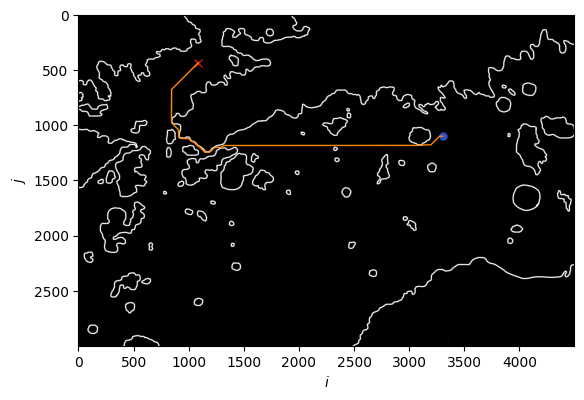

In [16]:
# Define Path location
path_filepath = os.path.join('Data', 'path.pkl')

if os.path.exists(path_filepath):
    with open(path_filepath, 'rb') as file:         # load path variable from Data
        path = pickle.load(file)

else:
    path = A_star(start, end, obstacleMap)          # find the path using A* algorithm
    path = np.array(path)                           # convert to numpy matrix

    with open('Data/path.pkl', 'wb') as file:       # save path variable to Data
        pickle.dump(path, file)

        
# Calculate the path length
path_length = compute_path_length(path)
print("Path Length:\t{:.2f} m".format(path_length*mapRes))


# Plot the Path
plt.figure("Task 2 - Pathfinding")
plt.imshow(obstacleMap, cmap='gray')
plt.plot(start[1], start[0], linestyle='none', marker='.', markersize=10, color='#304cc9', label='P1')
plt.plot(end[1], end[0], linestyle='none', marker='x', markersize=6, color='#e01414', label='P2')
plt.plot(path[:, 1], path[:, 0], c='#ff8903', linestyle='-', linewidth=1)
plt.xlabel(r'$i$')
plt.ylabel(r'$j$')
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('Images/Astar_path.jpg', format='jpg', dpi=figres)
plt.show()

### Task 3: Rover Localization - EKF

#### Define Problem Parameters

In [17]:
# Retrieve Trajectory from Task 1
q_real = P.T            # N x 3 matrix containing the real pose state at each time step
tspan_real = tspan      # N x 1 array containing state's timespan

# Define Model Parameters
sigma_x = 6                         # m
sigma_y = 6                         # m
sigma_theta = np.deg2rad(1)         # rad

# Define Initial Covariance Matrix
P0 = np.array([[sigma_x**2, 0, 0], [0, sigma_y**2, 0], [0, 0, sigma_theta**2]])

# Define Sensor Parameters
sigma_d = 4e-3                      # m
sigma_theta = np.deg2rad(0.05)      # rad


#### Define Observable Functions

##### $z = h(q, lm) \qquad \qquad H_q = \frac{\partial h}{\partial q}$

In [18]:
def h(q, x_lm, y_lm):
    '''
    Description: this function computes the observables from the state variable and the landmark position.
    '''

    range = np.linalg.norm([x_lm - q[0], y_lm - q[1]])
    bearing_angle = np.arctan2(y_lm - q[1], x_lm - q[0]) - q[2]

    return np.array([range, float(np.squeeze(bearing_angle))])

def get_Hq(q, lm):
    '''
    Description: this expression was found from an analytical standpoint using symbolic tools.
    '''

    x, y = q.item(0), q.item(1)
    xlm, ylm = np.squeeze(lm)[0:2]

    Hq = np.array([
        [(x-xlm)/(np.sqrt((x-xlm)**2 + (y-ylm)**2)), (y-ylm)/(np.sqrt((x-xlm)**2 + (y-ylm)**2)), 0], 
        [-(y-ylm)/((x-xlm)**2 + (y-ylm)**2), (x-xlm)/((x-xlm)**2 + (y-ylm)**2), -1]
        ])
    
    return Hq

#### Perform the Trajectory Reconstruction

In [19]:
def TrajectoryReconstruction(q_real, sigma_d, sigma_theta, lidar_maxrange=500, sigma_r=10e-2, sigma_beta=np.deg2rad(0.25)):
    
    q_est = [q_real[0]]     # initialize the estimated trajectory
    P_est = [P0]            # initialize covariance matrix

    q_dr = [q_real[0]]      # initialize the dead reckoning trajectory
    P_dr = [P0]             # initialize covariance matrix

    # Create measurement Covariance Matrix
    V = np.array([[sigma_d**2, 0], [0, sigma_theta**2]])

    for i in tqdm(range(1, len(q_real)), desc="Trajectory Reconstruction"):

        # Compute the odometry measurements in distance and orientation
        delta_d = np.linalg.norm(q_real[i][:2] - q_real[i-1][:2])           # delta in distance
        delta_theta = q_real[i][2] - q_real[i-1][2]                         # delta in orientation

        # Add noise to the odometry measurements
        nu_d = np.random.normal(0, sigma_d)
        nu_theta = np.random.normal(0, sigma_theta)

        # Retrieve last States and Covariance matrix
        x, y, theta = q_est[-1]
        x_dr, y_dr, theta_dr = q_dr[-1]
        P = P_est[-1]
        
        # Estimate the new States
        x_new = x + (delta_d + nu_d)*np.cos(theta)
        y_new = y + (delta_d + nu_d)*np.sin(theta)
        theta_new = theta + delta_theta + nu_theta

        x_new_dr = x_dr + (delta_d + nu_d)*np.cos(theta_dr)
        y_new_dr = y_dr + (delta_d + nu_d)*np.sin(theta_dr)
        theta_new_dr = theta_dr + delta_theta + nu_theta

        q_new = np.array([x_new, y_new, theta_new])
        q_new_dr = np.array([x_new_dr, y_new_dr, theta_new_dr])

        # Estimate the new Covariance Matrices
        Fq = np.array([[1, 0, -delta_d*np.sin(theta)], [0, 1, delta_d*np.cos(theta)], [0, 0, 1]])
        Fv = np.array([[np.cos(theta), 0], [np.sin(theta), 0], [0, 1]])
        P_new = Fq @ P @ Fq.T + Fv @ V @ Fv.T

        Fq_dr = np.array([[1, 0, -delta_d*np.sin(theta_dr)], [0, 1, delta_d*np.cos(theta_dr)], [0, 0, 1]])
        Fv_dr = np.array([[np.cos(theta_dr), 0], [np.sin(theta_dr), 0], [0, 1]])
        P_new_dr = Fq_dr @ P_dr[-1] @ Fq_dr.T + Fv_dr @ V @ Fv_dr.T

        # Append the new DR position and orientation
        q_dr.append(q_new_dr)
        P_dr.append(P_new_dr)


        # Check for visible Landmarks
        for x_lm, y_lm in zip(xLM, yLM):

            dist_lm = np.linalg.norm([x_lm - q_real[i][0], y_lm - q_real[i][1]])

            if dist_lm <= lidar_maxrange:
              
                # Compute the Observables from the real State -> observables that I should see
                z_real = h(q_real[i], x_lm, y_lm) + np.array([np.random.normal(0, sigma_r), np.random.normal(0, sigma_beta)])
                z_new = h(q_new, x_lm, y_lm)

                # Compute Kalman Gain
                Hq = get_Hq(q_new, (x_lm, y_lm))
                Hw = np.array([[1, 0], [0, 1]])
                W = np.array([[sigma_r**2, 0], [0, sigma_beta**2]])
                K = P_new @ Hq.T @ np.linalg.inv(Hq @ P_new @ Hq.T + Hw @ W @ Hw.T)

                # Perform State Update
                innovation = z_real - z_new
                innovation[1] = np.mod(innovation[1] + np.pi, 2 * np.pi) - np.pi    # wrap the angle
                q_upd = K @ innovation
                q_new = q_new + q_upd
                P_new = (np.eye(3) - K @ Hq) @ P_new

                # print('\nPerforming EKF @ step {:.0f}:\nq_est = '.format(i), q_new, '\nq_upd = ', q_upd)

                break
                

        # Append the new estimated position and orientation
        q_est.append(q_new)
        P_est.append(P_new)

    return np.array(q_est), P_est, np.array(q_dr), P_dr


# Compute Reconstructed Trajectory
lidar_maxrange = 500
q_est, P_est, q_dr, P_dr = TrajectoryReconstruction(q_real, sigma_d=4e-3, sigma_theta=np.deg2rad(0.05), lidar_maxrange=lidar_maxrange)

# Compute the square root of the determinant of each Covariance matrix
sqrt_det_P_est = [np.sqrt(np.linalg.det(P)) for P in P_est]
sqrt_det_P_dr = [np.sqrt(np.linalg.det(P)) for P in P_dr]

Trajectory Reconstruction: 100%|██████████| 332322/332322 [03:15<00:00, 1696.14it/s]


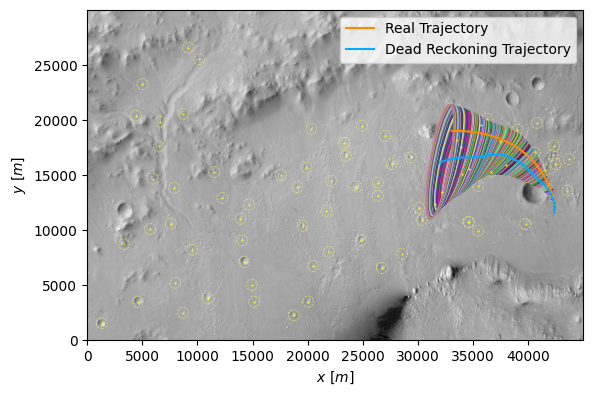

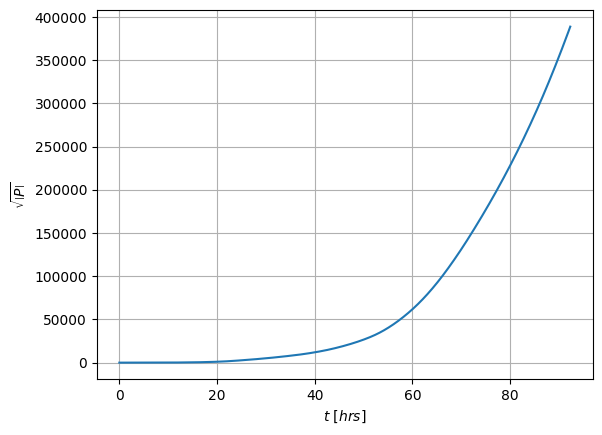

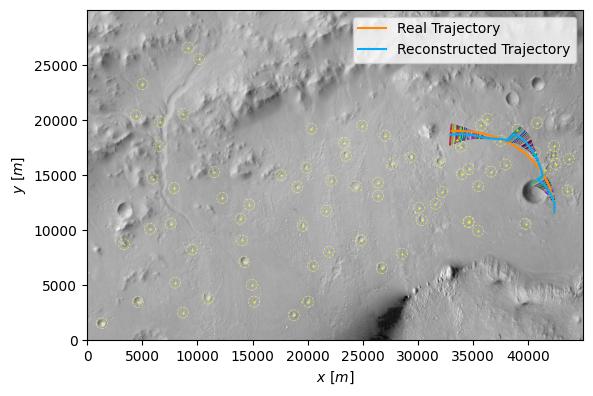

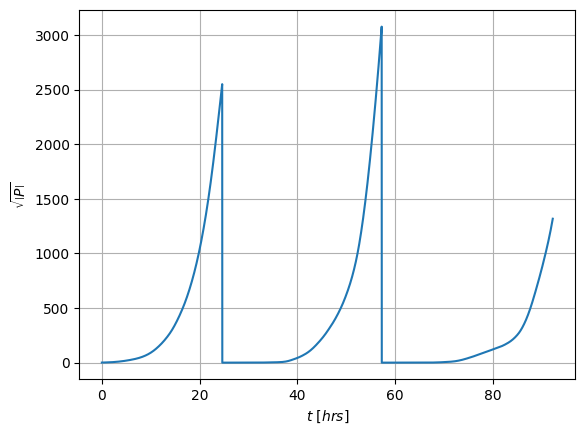

In [20]:
def plot_ellipses(q_est, P_est, plt, n_sigma=3, frequency=1):
    n = int(1 / frequency)      # n° of measurements acquisition per second
    num_ellipses = len(q_est) // n      # n° of ellipses
    for i in range(0, len(q_est), n):
        P = P_est[i]
        s, U = np.linalg.eig(P[0:2, 0:2])
        orientation = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width = np.sqrt(s[0])
        height = np.sqrt(s[1])
        
        color = np.random.rand(3,)    # random color

        # Plot the Ellipse
        ellipse = Ellipse(xy=q_est[i, :2], width=width*n_sigma, height=height*n_sigma, angle=orientation, facecolor='none', edgecolor=color, alpha=0.8)
        plt.gca().add_patch(ellipse)


# Visualize the Dead Reckoning Trajectory
plt.figure("Dead Reckoning Trajectory")
plot_map(map_image, Xvec, Yvec)
plt.plot(xLM, yLM, linestyle='none', marker='.', markersize=1, color='#ffff00')
for x, y in zip(xLM, yLM):
    circle = Circle((x, y), lidar_maxrange, linestyle='--',facecolor='none', edgecolor='#ffff6e', linewidth=0.5, alpha=0.6)
    plt.gca().add_patch(circle)
plt.plot(q_real[:, 0], q_real[:, 1], label='Real Trajectory', linestyle='-', color='#ff8903')
plt.plot(q_dr[:, 0], q_dr[:, 1], label='Dead Reckoning Trajectory', linestyle='-', color='#03abff')
plot_ellipses(q_dr, P_dr, plt, frequency=1e-3)
plt.xlabel(r'$x \ [m]$')
plt.ylabel(r'$y \ [m]$')
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('Images/DR.jpg', format='jpg', dpi=figres)
plt.show()

# Visualize the Covariance Matrix during Dead Reckoning
plt.figure("Dead Reckoning Covariance Matrix Evolution")
plt.plot(tspan/60**2, sqrt_det_P_dr)
plt.xlabel(r'$t \ [hrs]$')
plt.ylabel(r'$\sqrt{\left| P \right|}$')
plt.grid(True)
plt.savefig('Images/P_DR.jpg', format='jpg', dpi=figres)
plt.show()


# Visualize the Reconstructed Trajectory
plt.figure("EKF Trajectory")
plot_map(map_image, Xvec, Yvec)
plt.plot(xLM, yLM, linestyle='none', marker='.', markersize=1, color='#ffff00')
for x, y in zip(xLM, yLM):
    circle = Circle((x, y), lidar_maxrange, linestyle='--',facecolor='none', edgecolor='#ffff6e', linewidth=0.5, alpha=0.6)
    plt.gca().add_patch(circle)
plt.plot(q_real[:, 0], q_real[:, 1], label='Real Trajectory', linestyle='-', color='#ff8903')
plt.plot(q_est[:, 0], q_est[:, 1], label='Reconstructed Trajectory', linestyle='-', color='#03abff')
plot_ellipses(q_est, P_est, plt, frequency=1e-3)
plt.xlabel(r'$x \ [m]$')
plt.ylabel(r'$y \ [m]$')
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('Images/EKF.jpg', format='jpg', dpi=figres)
plt.show()

# Visualize the Covariance Matrix during EKF
plt.figure("EKF Covariance Matrix Evolution")
plt.plot(tspan/60**2, sqrt_det_P_est)
plt.xlabel(r'$t \ [hrs]$')
plt.ylabel(r'$\sqrt{\left| P \right|}$')
plt.grid(True)
plt.savefig('Images/P_EKF.jpg', format='jpg', dpi=figres)
plt.show()